In [82]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import allison
from allison.nn import Relu,Linear
from allison.nn import SGDMomentum
from allison.nn import Tensor,no_grad
from allison.nn import NeuralNetwork
from allison.nn import  MSELoss
from allison.datasets import train_test_split
from allison.metrics import r2_score

In [83]:
device  = 'gpu' if allison.is_cuda_available() else 'cpu'
device

Current GPU: NVIDIA GeForce RTX 4070 Laptop GPU
CUDA runtime version: 13000
CuPy version: 13.6.0


'gpu'

# Datos

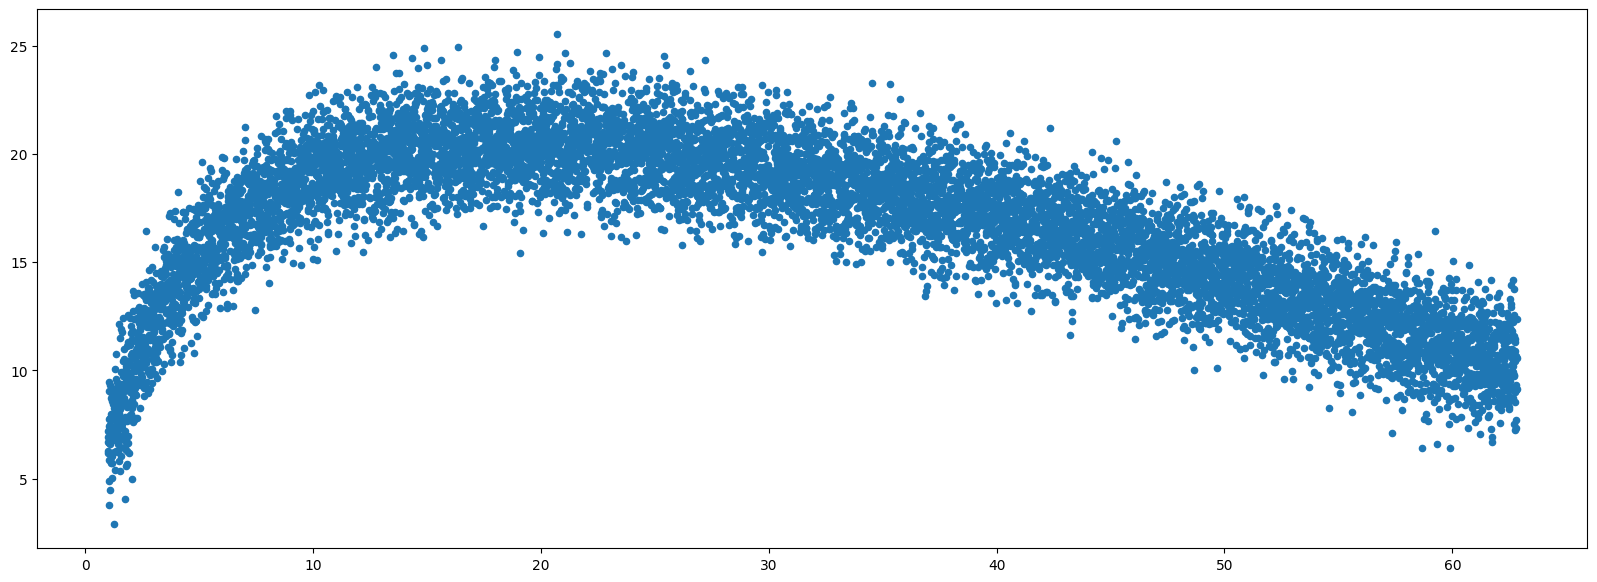

In [84]:
# Datos
points = 10000
x1 = np.linspace(1, 20*np.pi, points)
x2 = np.linspace(1, 20*np.pi, points)

# Definimos la salida
y = 10*np.log(x1+1) + -0.5*x2 + 1.5*np.random.randn(points)


data = pd.DataFrame({'x1': x1, 'x2': x2, 'y': y})
data.head()

plt.figure(figsize=(20,7))
plt.scatter(data['x2'], data['y'], s=20)
plt.show()


# Preprocessing

x1    31.848049
x2    31.848049
y     16.711144
dtype: float64
x1    17.857737
x2    17.857737
y      3.648964
dtype: float64


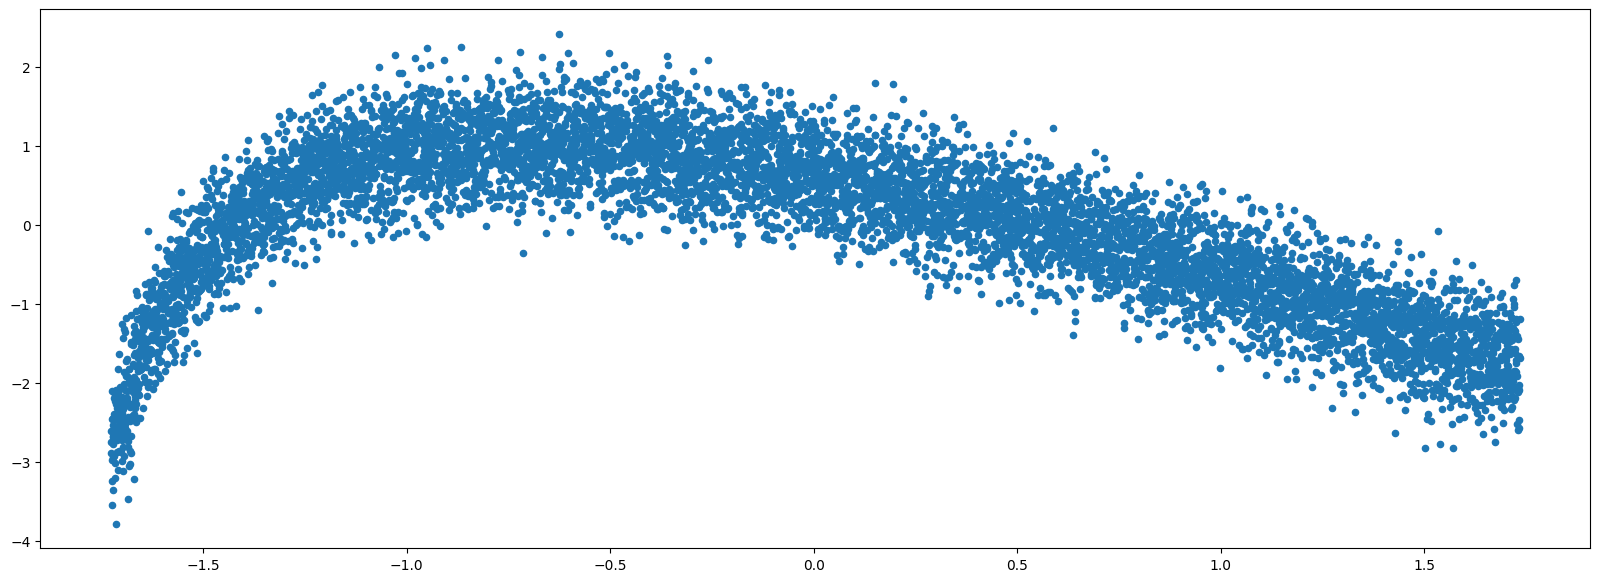

In [85]:
# Train test split and normalization

df_train, df_test = train_test_split(data, test_size=0.2, random_state=42, shuffle=True)


def_train_mean = df_train.mean()
def_train_std = df_train.std()

print(def_train_mean)
print(def_train_std)

df_train = (df_train-def_train_mean)/def_train_std
df_test = (df_test-def_train_mean)/def_train_std

plt.figure(figsize=(20,7))
plt.scatter(df_train['x2'], df_train['y'], s=20)
plt.show()


In [86]:
X_train = Tensor(df_train[['x1', 'x2']].values).to(device)
Y_train = Tensor(df_train[['y']].values).to(device)

X_test = Tensor(df_test[['x1', 'x2']].values).to(device)
Y_test = Tensor(df_test[['y']].values).to(device)


print(f"X_train shape: {X_train.shape}, device: {X_train.device}")
print(f"Y_train shape: {Y_train.shape}. device: {Y_train.device}")
print(f"X_test shape: {X_test.shape}, device: {X_test.device}")
print(f"Y_test shape: {Y_test.shape}, device: {Y_test.device}")

X_train shape: (8000, 2), device: gpu
Y_train shape: (8000, 1). device: gpu
X_test shape: (2000, 2), device: gpu
Y_test shape: (2000, 1), device: gpu


In [87]:
class Network(NeuralNetwork):
    def __init__(self):
        super().__init__()
        self.fc1 = Linear(2, 64)
        self.relu = Relu()
        self.fc2 = Linear(64, 32)
        self.fc3 = Linear(32, 1)

    def forward(self, x: Tensor) -> Tensor:
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x
    
net = Network()

In [88]:
net.parameters()

[Tensor(
 [[ 1.61599406  0.82602879  2.76252524 -1.55361243 -0.5060347  -0.94302519
    1.22936831 -0.22055036  0.1895162   0.63368553 -1.45478885 -0.62134896
    0.99726595 -0.5480879  -1.71364297 -0.90226289 -0.28626805  0.16676052
   -0.07081331 -0.61421784  0.93931344 -0.12906094  0.20940136 -0.56095598
    1.50894026 -0.39163111  0.07469287  1.03499944  0.28004226  0.2550897
   -1.97365551  0.680635    0.05558694  0.5415651   0.18321305 -0.55915756
    0.89430717  0.19812661 -1.28938649  1.30851716 -1.43047956  0.90092923
    1.48693177 -1.10629544 -0.12276179 -0.21594825 -0.17097116  1.83023836
   -1.09471887 -0.30656704  1.5033225  -0.32294883 -0.93577972  0.26301468
    0.80564054 -0.39284097  0.55436839 -1.37661509 -1.32102708 -0.44008628
    0.59001742  0.76149798 -1.18201605  0.7244207 ]
  [ 0.16650704 -0.87920469 -1.33418835  0.22982315  1.28956322  0.03552243
   -0.93492085 -1.86802229  1.52949085  1.04185061  0.30207685  1.47799397
    0.2239191  -0.53103695  0.55513225 -

In [89]:
net.to('gpu')

In [90]:
net.parameters()

[Tensor(
 [[ 1.61599406  0.82602879  2.76252524 -1.55361243 -0.5060347  -0.94302519
    1.22936831 -0.22055036  0.1895162   0.63368553 -1.45478885 -0.62134896
    0.99726595 -0.5480879  -1.71364297 -0.90226289 -0.28626805  0.16676052
   -0.07081331 -0.61421784  0.93931344 -0.12906094  0.20940136 -0.56095598
    1.50894026 -0.39163111  0.07469287  1.03499944  0.28004226  0.2550897
   -1.97365551  0.680635    0.05558694  0.5415651   0.18321305 -0.55915756
    0.89430717  0.19812661 -1.28938649  1.30851716 -1.43047956  0.90092923
    1.48693177 -1.10629544 -0.12276179 -0.21594825 -0.17097116  1.83023836
   -1.09471887 -0.30656704  1.5033225  -0.32294883 -0.93577972  0.26301468
    0.80564054 -0.39284097  0.55436839 -1.37661509 -1.32102708 -0.44008628
    0.59001742  0.76149798 -1.18201605  0.7244207 ]
  [ 0.16650704 -0.87920469 -1.33418835  0.22982315  1.28956322  0.03552243
   -0.93492085 -1.86802229  1.52949085  1.04185061  0.30207685  1.47799397
    0.2239191  -0.53103695  0.55513225 -

In [91]:
criterion = MSELoss()
optimizer = SGDMomentum(net.parameters(), learning_rate=1e-3, momentum=0.9)

In [92]:
out = net(X_train)
out

Tensor(
[[0.44840774]
 [0.14094315]
 [1.50768592]
 ...
 [0.86541514]
 [2.0274462 ]
 [0.68086719]], shape=(8000, 1), device=gpu, requires_grad=True)

In [93]:
out._prev

{Tensor(
 [[0.44840774]
  [0.14094315]
  [1.50768592]
  ...
  [0.86541514]
  [2.0274462 ]
  [0.68086719]], shape=(8000, 1), device=gpu, requires_grad=True),
 Tensor(
 [[0.]], shape=(1, 1), device=gpu, requires_grad=True)}

In [94]:
# %%
# Bucle de entrenamiento mejorado
for epoch in range(10000 + 1):
    Y_pred = net(X_train)
    loss = criterion(Y_train,Y_pred)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        r2_train = r2_score(Y_train, Y_pred)
        with no_grad():
            Y_pred = net(X_test)
            r2_test = r2_score(Y_test, Y_pred)
        print(f"Epoch {epoch:5d} | Loss: {loss.data:.4f} | R2_Train: {100*r2_train:5.2f} % | R2_Test: {100*r2_test:5.2f} %")
        if r2_test > 0.95:  # Mejoramos el criterio de parada
            print(f"Entrenamiento completado en {epoch} epochs!")
            break

Epoch     0 | Loss: 3.0261 | R2_Train: -202.65 % | R2_Test: -162.03 %
Epoch   100 | Loss: 0.4381 | R2_Train: 56.19 % | R2_Test: 57.92 %
Epoch   200 | Loss: 0.3665 | R2_Train: 63.35 % | R2_Test: 64.79 %
Epoch   300 | Loss: 0.3463 | R2_Train: 65.37 % | R2_Test: 66.63 %
Epoch   400 | Loss: 0.3337 | R2_Train: 66.62 % | R2_Test: 67.83 %
Epoch   500 | Loss: 0.3210 | R2_Train: 67.89 % | R2_Test: 69.09 %
Epoch   600 | Loss: 0.3087 | R2_Train: 69.13 % | R2_Test: 70.34 %
Epoch   700 | Loss: 0.2980 | R2_Train: 70.20 % | R2_Test: 71.40 %
Epoch   800 | Loss: 0.2867 | R2_Train: 71.33 % | R2_Test: 72.53 %
Epoch   900 | Loss: 0.2735 | R2_Train: 72.64 % | R2_Test: 73.85 %
Epoch  1000 | Loss: 0.2610 | R2_Train: 73.90 % | R2_Test: 75.08 %
Epoch  1100 | Loss: 0.2517 | R2_Train: 74.82 % | R2_Test: 75.95 %
Epoch  1200 | Loss: 0.2433 | R2_Train: 75.66 % | R2_Test: 76.73 %
Epoch  1300 | Loss: 0.2357 | R2_Train: 76.43 % | R2_Test: 77.45 %
Epoch  1400 | Loss: 0.2288 | R2_Train: 77.12 % | R2_Test: 78.11 %
Epoch 

In [95]:
r2_score(Y_test, Y_pred)

array(0.83530927)

In [96]:
# %%
# Visualización final

with no_grad():
    y_pred = net(X_test)

r2 = r2_score(Y_test, y_pred)


Text(0.5, 1.0, 'Polinomic Regression on Test Data(Accuracy:83.53%)')

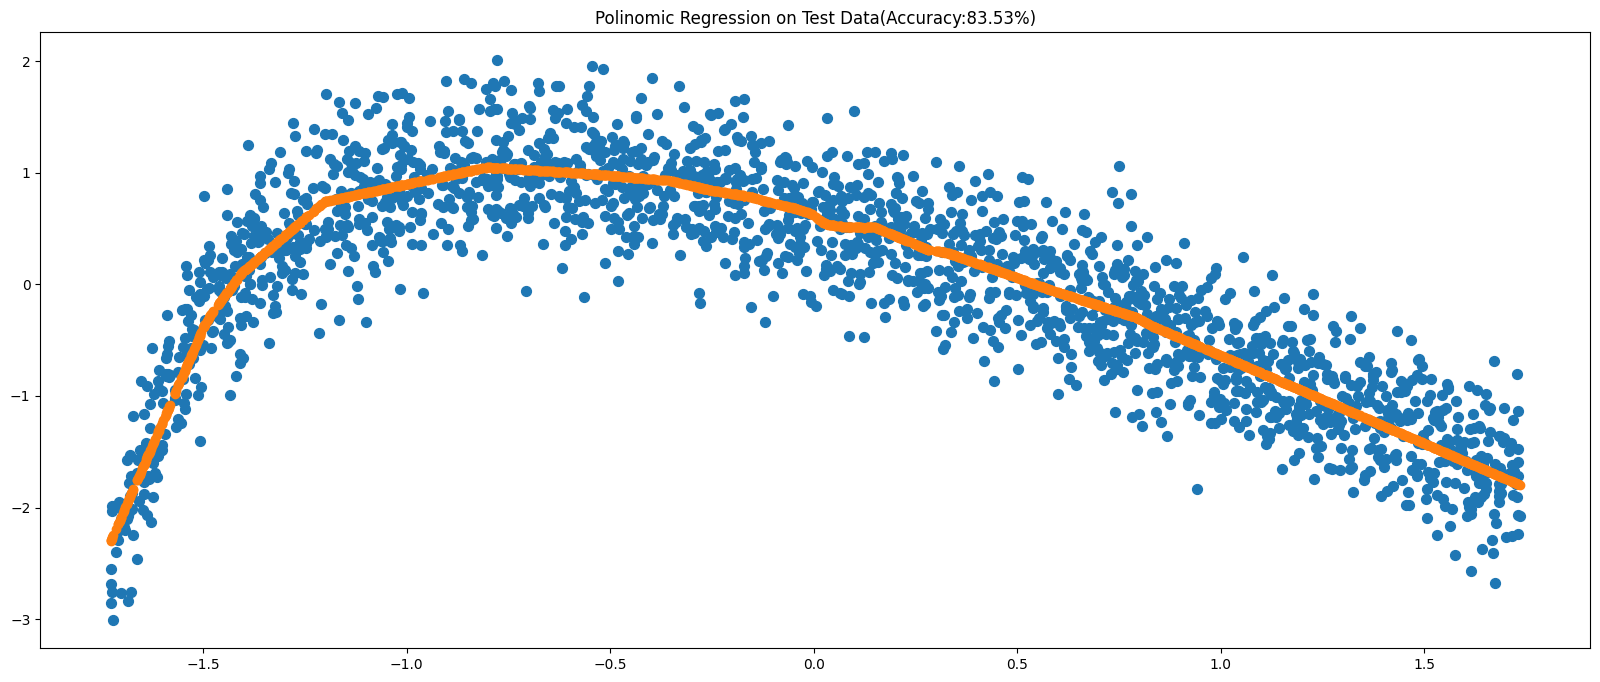

In [97]:
plt.figure(figsize=(20,8))
plt.scatter(X_test.to('cpu').data[:,0],Y_test.to('cpu').data,s=50)
plt.scatter(X_test.to('cpu').data[:,0],y_pred.to('cpu').data)
plt.title(f'Polinomic Regression on Test Data(Accuracy:{r2*100:.2f}%)')

# Rescaling

In [98]:
print(y_pred.data)

[[-1.14313335]
 [-0.28518547]
 [ 0.07096872]
 ...
 [ 0.50996258]
 [-0.01697835]
 [-0.29452437]]


In [99]:
y_final = y_pred.data * def_train_std['y'] + def_train_mean['y']
y_final_rescaled = y_final.flatten()
print(y_final_rescaled)

[12.53989179 15.67051278 16.97010661 ... 18.57197944 16.64919089
 15.63643547]
